# A/B testing with binary data: Two sample proportions test for a marketing campaign

In this notebook, I would like to apply **two sample proportions test** on marketing campagn data.

I am using a dataset of a marketing campaign from [Kaggle](https://www.kaggle.com/faviovaz/marketing-ab-testing).

The idea of the dataset is to analyze the groups, find if the ads were successful, how much the company can make from the ads, and if the difference between the groups is statistically significant.

**Data dictionary:**

* index: Row index
* user id: User ID (unique)
* test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
* converted: If a person bought the product then True, else is False
* total ads: Amount of ads seen by person
* most ads day: Day that the person saw the biggest amount of ads
* most ads hour: Hour of day that the person saw the biggest amount of ads.

I would like to know whether there is any statistically significant difference in the purchasing behavior of two groups. First, let us conduct a simple EDA and then, answer to the question.

## Data wrangling

In [1]:
import pandas as pd
import numpy as np

import math
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats

#import seaborn as sns
import matplotlib.pyplot as plt

/Users/aigerimshopenova/opt/anaconda3/envs/dsnd/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv("marketing_AB.csv")

In [3]:
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


Let us drop unnamed column because it duplicates the existing row indexes.

In [5]:
df.columns

Index(['Unnamed: 0', 'user id', 'test group', 'converted', 'total ads',
       'most ads day', 'most ads hour'],
      dtype='object')

In [6]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [7]:
# Let us rename columns
df.columns = ['user_id', 'test_group', 'converted', 'total_ads', 'most_ads_day', 'most_ads_hour']

In [8]:
# Let's rename 'ad' and 'psa' to 'treatmen' and 'control', correspondingly
df.replace({'test_group':{'ad':'treatment',
                          'psa':'control'}}, inplace=True)

In [9]:
# Check the results
df.head(2)

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,treatment,False,130,Monday,20
1,1119715,treatment,False,93,Tuesday,22


## EDA

Let us explore the data to have a better understanding of it.

### How many unique users participated in the campaign?

In [10]:
df['user_id'].nunique()

588101

In [11]:
df.shape[0]

588101

It seems 588,101 unique users participated in the campaign. Each row represents a record for a unique user.

### What is the proportion between two groups?

In [12]:
df['test_group'].value_counts()

treatment    564577
control       23524
Name: test_group, dtype: int64

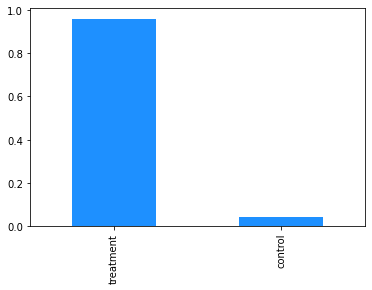

In [13]:
df['test_group'].value_counts(normalize=True).plot.bar(color='dodgerblue');

About 96% of the records belong to the treatment group, which has seen the add.

### What is the conversion rate?

In this case, conversion means that a user made a purchase. Let us look at the overall conversion rate and then check the conversion rate for each group.

#### Overall conversion rate

In [14]:
df['converted'].value_counts()

False    573258
True      14843
Name: converted, dtype: int64

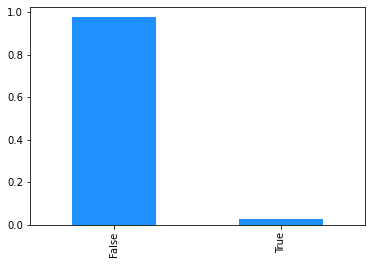

In [15]:
df['converted'].value_counts(normalize=True).plot.bar(color='dodgerblue');

About 2.5% of all the customers made a purchase.

#### Conversion rate per group

In [16]:
df_gr = df.groupby('test_group').agg({'converted':'sum',
                                      'user_id':'nunique'}).reset_index()

In [17]:
df_gr

,test_group,converted,user_id
0,control,420,23524
1,treatment,14423,564577


In [18]:
df_gr.columns = ['test_group', 'converted', 'unique_users']

In [19]:
df_gr['proportion'] = (df_gr['converted']) / df_gr['unique_users']

In [20]:
df_gr

,test_group,converted,unique_users,proportion
0,control,420,23524,0.017854
1,treatment,14423,564577,0.025547


It is clear that the treatment group has a higher conversion rate than the control group, 2.55% vs 1.78%. Let us understand whether this difference is statistically significant or not.

### How many total ads did the groups receive? What is an average time to receive the ads?

In [21]:
df[['total_ads', 'most_ads_hour']].describe()

,total_ads,most_ads_hour
count,588101.000000,588101.000000
mean,24.820876,14.469061
std,43.715181,4.834634
min,1.000000,0.000000
25%,4.000000,11.000000
50%,13.000000,14.000000
75%,27.000000,18.000000
max,2065.000000,23.000000


* The median value for the number of ads is 13, while the mean value is 24.8. 
* On average, people saw the ads at around 2 PM (mean value is about 14.5).

### What is the most popular day of a week for each group?

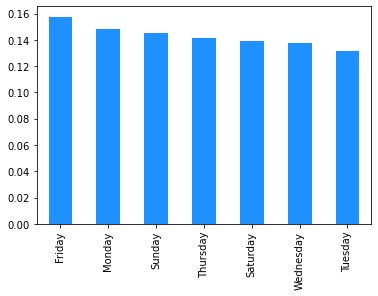

In [22]:
df['most_ads_day'].value_counts(normalize=True).plot.bar(color='dodgerblue');

The most popular day of a week is Friday for receiving an ad.

In [23]:
df.groupby(['test_group',
            'most_ads_day']).agg({'user_id':'nunique', 
                                  'converted':'sum'}).reset_index().sort_values(by='user_id',
                                                                                ascending=False)

,test_group,most_ads_day,user_id,converted
7,treatment,Friday,88805,1995
8,treatment,Monday,83571,2778
10,treatment,Sunday,82332,2027
11,treatment,Thursday,79077,1711
9,treatment,Saturday,78802,1679
13,treatment,Wednesday,77418,1963
12,treatment,Tuesday,74572,2270
4,control,Thursday,3905,79
0,control,Friday,3803,62
1,control,Monday,3502,79


* Friday is the most active day for both groups in terms of viewing the ad. 
* Treatment group has the highest purchasing rate on Monday rather than Friday. Even though Friday is the most active day
* The highest number of purchases for the control group happened on Friday and Monday.

## Two sample proportions test

### Hyphothesis testing

Let us name the conversion rate for the control group as proportion 1 (p1) and the conversion rate for the treatemnt group as proportion 2 (p2). 

Then,
* H0: p1 = p2
* H1: p1 < p2 (left-tailed)

Basically, we null hyphothesis states that there is no difference in the proportions, while the alternative hyphothesis says that proportion 1 is less than proportion 2. I.e., there is an effect of ads.

### Estimate sample size

In [24]:
df_gr

,test_group,converted,unique_users,proportion
0,control,420,23524,0.017854
1,treatment,14423,564577,0.025547


In [25]:
def z_calc(p1, p2, n1, n2):
    p_star = (p1*n1 + p2*n2) / (n1 + n2)
    return (p2 - p1) / math.sqrt(p_star*(1 - p_star)*((1.0 / n1) + (1.0 / n2)))

In [26]:
# p_diff = p2-p1
def sample_required(p1, p_diff, alpha):
    if p_diff <= 0:
        raise ValueError("p_diff must be > 0")
    n = 1
    while True:
        z = z_calc(p1, p1+p_diff, n1=n, n2=n)
        p = 1 - stats.norm.cdf(z)
        if p < alpha:
            break
        n += 1
    return n

In [27]:
sample_size = sample_required(df_gr[['proportion'][0]][0],
                              (df_gr[['proportion'][0]][1] - df_gr[['proportion'][0]][0]),
                               0.05)

In [28]:
sample_size

1942

The minimum sample size is 1,942 for each group.

### Take a random sample

In [29]:
df.head(2)

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,treatment,False,130,Monday,20
1,1119715,treatment,False,93,Tuesday,22


In [30]:
df_tr = df[df['test_group'] == 'treatment']
df_ctrl = df[df['test_group'] == 'control']

Let us take sample size = 20,000, which is higher than the required sample size (1,942) and less than the total number of unique users in the smallest group - control group (23,524).

In [31]:
df_tr_sample = df_tr.sample(n=20000, random_state=23)
df_ctrl_sample = df_ctrl.sample(n=20000, random_state=23)

In [32]:
df_sample = pd.concat([df_tr_sample, df_ctrl_sample], ignore_index=True)

In [33]:
df_sample.head(2)

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1582256,treatment,False,39,Sunday,21
1,1065131,treatment,False,37,Wednesday,16


In [34]:
df_sample.shape

(40000, 6)

In [35]:
df_sample_gr = df_sample.groupby('test_group').agg({'converted':'sum',
                                                    'user_id':'nunique'}).reset_index()

In [36]:
df_sample_gr.columns = ['test_group', 'converted', 'unique_users']

In [37]:
df_sample_gr['proportion'] = (df_sample_gr['converted']) / df_sample_gr['unique_users']

In [38]:
df_sample_gr

,test_group,converted,unique_users,proportion
0,control,348,20000,0.01740
1,treatment,497,20000,0.02485


### Estimate statistical significance

In [39]:
number_of_successes = [348, 497]
total_sample_sizes = [20000, 20000]

In [40]:
test_stat, p_value = proportions_ztest(number_of_successes, total_sample_sizes, alternative='smaller')

In [41]:
print("Computed z-test statistic: ", test_stat)

Computed z-test statistic:  -5.180769799760474


In [42]:
print("Computed p-value: ", p_value)

Computed p-value:  1.1048602970777487e-07


Suppose that a significance level of 5% was established before the start of the experiment. In that case, we see that our result is statistically significant and we have an evidence to reject the null hyphothesis.

## Summary

In [ ]:
from numpy import random
sns.set_style(style='white') 

In [ ]:
sns.set(rc = {'figure.figsize':(12,6)})
ax = sns.distplot(random.binomial(n=2000, p=0.5, size=1000), hist=True, label='binomial', color='dodgerblue');
ax.set_xlabel("Events", fontsize = 16)
ax.set_ylabel("Probability", fontsize = 16)
ax.set_title("Binomial Distribution (n=200, p=0.5)", fontsize = 20)
ax.set_facecolor('white')